In [19]:
from pathlib import Path
import sys
import os
path_root = Path(os.getcwd()).parents[1]
sys.path.append(str(path_root))

In [20]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

In [21]:
with open('../../outputs/gpt/train_metrics.pickle', 'rb') as f:
    training_metrics = pickle.load(f)

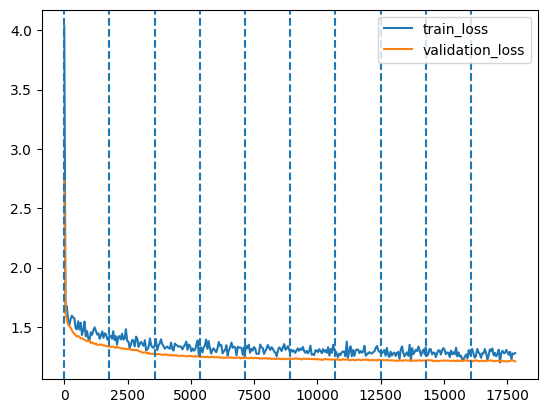

In [22]:
plt.plot(*list(zip(*[(m['global_step'], m['train_loss']) for m in training_metrics])), label='train_loss')
plt.plot(*list(zip(*[(m['global_step'], m['validation_loss']) for m in training_metrics])), label='validation_loss')
for point in [m['global_step'] for i, m in enumerate(training_metrics) if training_metrics[i-1]['epoch'] != m['epoch']]:
    plt.axvline(x=point, linestyle='--')
plt.legend()
plt.show()

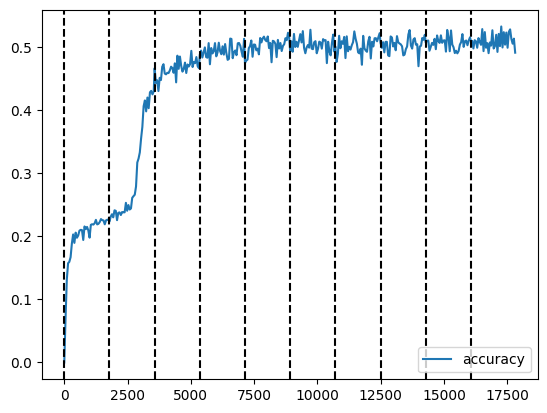

In [23]:
plt.plot(*list(zip(*[(m['global_step'], m['accuracy'].item()) for m in training_metrics])), label='accuracy')# plt.plot(*list(zip(*[(m['global_step'], m['perplexity'].item()) for m in training_metrics])), label='perplexity')
for point in [m['global_step'] for i, m in enumerate(training_metrics) if training_metrics[i-1]['epoch'] != m['epoch']]:
    plt.axvline(x=point, linestyle='--', c='black')
plt.legend()
plt.show()

In [24]:
min([m['validation_loss'] for m in training_metrics])

1.208070158958435

# Final Evaluation Outputs

In [25]:
food_names = np.load('../../../data/local/final/full/food_names/0.npy', allow_pickle=True)
food_names.shape

(1110,)

In [26]:
input = training_metrics[-1]['input']
output = training_metrics[-1]['output']

KeyError: 'input'

In [ ]:
pd.set_option('max_colwidth', None)

In [ ]:
input[1].shape

TypeError: 'method' object is not subscriptable

In [ ]:
pd.DataFrame({
    'input': food_names[input[0]].tolist(), 
    'label': food_names[input[1]].tolist(),
    'prediction': food_names[output.argmax(2)].tolist(), 
})

TypeError: 'method' object is not subscriptable

This way of evaluating the model is wrong. There are repeated predicted tokens here because it is predicting from the input, and the most probable token hasn't yet appeared in the input.

We need to evaluate the model by simply looking at generations that it does.

In [27]:
from recipe_generator.models.gpt import GPTLanguageModel
from recipe_generator.config.gpt import GPTConfig

food_vectors = torch.tensor(np.load('../../../data/local/final/full/food_compounds/0.npy'), dtype=torch.float) #TODO: unnecessary dependancy
model = GPTLanguageModel(GPTConfig(), food_vectors)

model.load_state_dict(torch.load('../../outputs/gpt/model.pt'))
model.to('cuda');
model.eval();

In [28]:
np.argwhere(food_names=='chicken')

array([[418]])

In [29]:
context = (torch.ones((5,1), dtype=torch.long)*418).to('cuda')
context

tensor([[418],
        [418],
        [418],
        [418],
        [418]], device='cuda:0')

In [30]:
generations = model.generate(context, 14).to('cpu')
food_names[generations]

array([['chicken', 'pate', 'pate', 'cumin', 'garlic', 'garlic', 'lemon',
        'lemon', 'coriander', 'pepper', 'pepper', 'pepper', '<end>',
        '<pad>', '<pad>'],
       ['chicken', 'potato', 'sauce', 'sauce', '<end>', '<pad>', '<pad>',
        '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>',
        '<pad>'],
       ['chicken', 'salad dressing', 'lemon', 'cheese', 'broccoli',
        'bread', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>',
        '<pad>', '<pad>', '<pad>'],
       ['chicken', '<unknown>', '<unknown>', 'common oregano',
        'onion-family vegetable', 'ketchup', 'salt', 'salt', 'topping',
        'topping', 'cream', '<end>', '<pad>', '<pad>', '<pad>'],
       ['chicken', 'red wine', 'port wine', 'soy sauce', 'sugar',
        'ginger', 'garlic', 'garlic', 'chestnut', 'flour', 'flour',
        'salt', '<end>', '<pad>', '<pad>']], dtype=object)